In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import tensorflow as tf
import ast

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, TFBertModel
import MeCab
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

C:\Users\kkk00\anaconda3\envs\python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
# GPU 메모리 최적화
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [6]:
## 파일 로드
path = '~/2024_DKTC/data/Final_DATASET_PPC.csv'
data= pd.read_csv(path)

data['pre_processed_final'] = data['pre_processed_final'].apply(lambda x: ast.literal_eval(x))

In [7]:
data['class'].value_counts()

일반 대화          9685
기타 괴롭힘 대화      4775
갈취 대화          4564
직장 내 괴롭힘 대화    3659
협박 대화          3563
Name: class, dtype: int64

In [8]:
data.head()

,Unnamed: 0,class,pre_processed_final
0,0,협박 대화,"[지금, 자살, 싶, 으시, ᆫ가요, 아니, 죄송, 어요, 죽, 혼자, 죽, 예요,..."
1,1,협박 대화,"[여기, 길동, 경찰서, ᆸ니다, 시, 분, 마트, 폭발물, 설치, 뭐, 라고, 요..."
2,2,협박 대화,"[어떻, 지내, 시, 나요, 장기, 잘, 보관, 계시, 죠, 장기, 여기, 보관, ..."
3,3,협박 대화,"[친구, 곳, 날리, 버리, 세, 요, 정말, 모르, 어요, 친구, 함께, 달리, ..."
4,4,협박 대화,"[갚, 기, 돈, 데, 어떻, 갚, 어요, 남, 돈, 빼앗, 여기, 희희낙락, ᆸ니..."


In [9]:
df = data.copy()

# 토큰 리스트를 문자열로 변환하여 'processed_text' 컬럼 생성
df['processed_text'] = df['pre_processed_final'].apply(lambda tokens: ' '.join(tokens))

In [10]:
df.head()

,Unnamed: 0,class,pre_processed_final,processed_text
0,0,협박 대화,"[지금, 자살, 싶, 으시, ᆫ가요, 아니, 죄송, 어요, 죽, 혼자, 죽, 예요,...",지금 자살 싶 으시 ᆫ가요 아니 죄송 어요 죽 혼자 죽 예요 관여 바라 나요 정말 ...
1,1,협박 대화,"[여기, 길동, 경찰서, ᆸ니다, 시, 분, 마트, 폭발물, 설치, 뭐, 라고, 요...",여기 길동 경찰서 ᆸ니다 시 분 마트 폭발물 설치 뭐 라고 요 다시 번 말씀 드리 ...
2,2,협박 대화,"[어떻, 지내, 시, 나요, 장기, 잘, 보관, 계시, 죠, 장기, 여기, 보관, ...",어떻 지내 시 나요 장기 잘 보관 계시 죠 장기 여기 보관 이번 마지막 ᆸ니다 갑자...
3,3,협박 대화,"[친구, 곳, 날리, 버리, 세, 요, 정말, 모르, 어요, 친구, 함께, 달리, ...",친구 곳 날리 버리 세 요 정말 모르 어요 친구 함께 달리 는데 친구 사라지 어요 ...
4,4,협박 대화,"[갚, 기, 돈, 데, 어떻, 갚, 어요, 남, 돈, 빼앗, 여기, 희희낙락, ᆸ니...",갚 기 돈 데 어떻 갚 어요 남 돈 빼앗 여기 희희낙락 ᆸ니다 비용 지불 있 죽 예...


In [11]:
# 레이블 인코딩
label_mapping = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화' : 4
}
df['class'] = df['class'].map(label_mapping)

In [12]:
from transformers import BertTokenizer, TFBertModel

# 사전 훈련된 한국어 BERT 모델과 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('kykim/bert-kor-base')
bert_model = TFBertModel.from_pretrained('kykim/bert-kor-base')

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at kykim/bert-kor-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


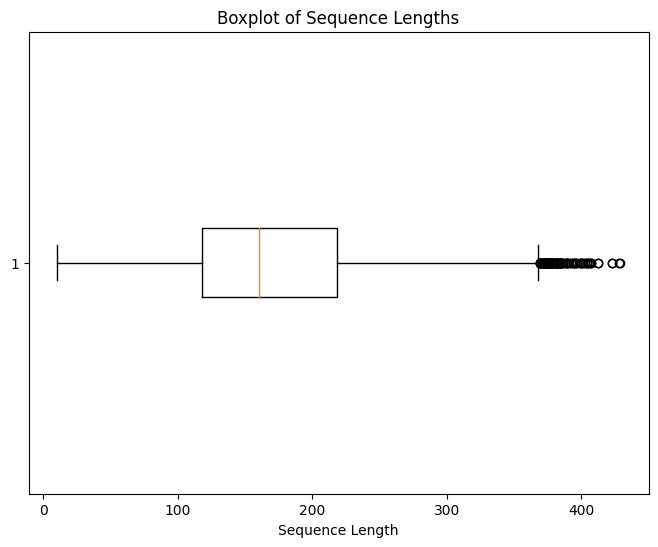

In [13]:
# 시퀀스 길이 박스플롯을 위해 패딩 전에 시퀀스 길이 계산
sequence_lengths = df['pre_processed_final'].apply(len).tolist()

plt.figure(figsize=(8, 6))
plt.boxplot(sequence_lengths, vert=False)
plt.title('Boxplot of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.show()

In [63]:
# 토큰화 함수 정의 (패딩 전에 시퀀스 길이 확인 완료)
def tokenize_texts(texts, tokenizer, max_length):
    return tokenizer(
        texts.tolist(),
        padding='max_length',  # 시퀀스를 max_length로 패딩
        truncation=True,       # max_length를 초과하는 시퀀스는 자름
        max_length=max_length,
        return_tensors='tf'    # 텐서 형식으로 반환
    )

In [64]:
# 최대 시퀀스 길이 결정
max_seq_len = 80  # 메모리 부족 문제 해결을 위해 시퀀스 길이 줄이기

In [65]:
# 토큰화 수행: 'processed_text' 컬럼 사용
tokenized_data = tokenize_texts(df['processed_text'], tokenizer, max_seq_len)

input_ids = tokenized_data['input_ids']
attention_mask = tokenized_data['attention_mask']

# 레이블 준비
y = df['class'].values

In [66]:
from sklearn.model_selection import train_test_split

# input_ids와 attention_mask를 넘파이 배열로 변환 (이전 코드의 부분)
input_ids_np = input_ids.numpy()
attention_mask_np = attention_mask.numpy()

# 학습과 검증 데이터를 8:2로 나눔 (클래스 비율 유지)
X_train_input_ids, X_val_input_ids, X_train_attention_mask, X_val_attention_mask, y_train, y_val = train_test_split(
    input_ids_np,       # input_ids
    attention_mask_np,  # attention_mask
    y,                  # target (class labels)
    test_size=0.2,      # 검증 데이터 비율 20%
    random_state=25,   # 시드 고정
    stratify=y          # 클래스 비율 유지
)

In [67]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, Dense, Input
from tensorflow.keras.models import Model

def build_classification_model(max_seq_len, num_classes):
    # 입력 레이어 정의
    input_ids = Input(shape=(max_seq_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_seq_len,), dtype=tf.int32, name="attention_mask")
    
    # BERT 모델을 통해 임베딩 획득
    bert_outputs = bert_model(input_ids, attention_mask=attention_mask)
    
    bert_model.trainable = True
    
    # Conv1D 레이어 추가 (임베딩된 마지막 히든 상태에 적용)
    conv = Conv1D(256, kernel_size=3, activation='relu')(bert_outputs.last_hidden_state)  # (batch_size, max_seq_len, 128)
    
    # 풀링 레이어 (Conv1D 이후)
    pooled = GlobalMaxPooling1D()(conv)  # (batch_size, 128)
    
    # 드롭아웃 및 Dense 레이어
    dropout_2 = Dropout(0.3)(pooled)
    dense = Dense(128, activation='relu')(dropout_2)
    
    # 출력 레이어 (클래스 수에 맞게 설정)
    outputs = Dense(num_classes, activation='softmax')(dense)
    
    # 모델 정의
    model = Model(inputs=[input_ids, attention_mask], outputs=outputs)
    
    return model

In [68]:
# 클래스 수 설정
num_classes = 5  # 필요에 따라 조정

# 모델 생성
model = build_classification_model(max_seq_len, num_classes)

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 요약 확인
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 80)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 80)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    multiple             118297344   ['input_ids[0][0]',              
                                                                  'attention_mask[0][0]']         
                                                                                                  
 conv1d_1 (Conv1D)              (None, 78, 128)      295040      ['tf_bert_model[4][0]']    

In [69]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

# 체크포인트 저장 디렉토리 생성
checkpoint_dir = 'checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# 조기 종료 및 모델 체크포인트 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_model.h5'),  # 체크포인트 저장 경로
    monitor='val_loss',                                      # 모니터링할 지표
    save_best_only=True,                                     # 최상의 모델만 저장
    save_weights_only=True,                                  # 가중치만 저장
    verbose=1                                                # 저장 시 메시지 출력
)

# 추가적인 학습률 스케줄러 (선택 사항)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-6,
    verbose=1
)

# 콜백 리스트에 추가
callbacks = [early_stopping, model_checkpoint, reduce_lr]

In [70]:
import tensorflow as tf

# 사용 가능한 GPU 장치 확인
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"사용 가능한 GPU 장치: {gpus}")
else:
    print("GPU를 찾을 수 없습니다. CPU를 사용 중입니다.")

사용 가능한 GPU 장치: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [71]:
# 모델 학습
history = model.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train,
    validation_data=([X_val_input_ids, X_val_attention_mask], y_val),
    epochs=20,
    batch_size=8, 
    callbacks=callbacks
)

Epoch 1/20
2625/2625 [==============================] - ETA: 0s - loss: 0.0910 - accuracy: 0.9769
Epoch 00001: val_loss improved from inf to 0.07012, saving model to checkpoints\best_model.h5
2625/2625 [==============================] - 262s 94ms/step - loss: 0.0910 - accuracy: 0.9769 - val_loss: 0.0701 - val_accuracy: 0.9796 - lr: 3.0000e-05
Epoch 2/20
2625/2625 [==============================] - ETA: 0s - loss: 0.0612 - accuracy: 0.9833
Epoch 00002: val_loss improved from 0.07012 to 0.05961, saving model to checkpoints\best_model.h5
2625/2625 [==============================] - 247s 94ms/step - loss: 0.0612 - accuracy: 0.9833 - val_loss: 0.0596 - val_accuracy: 0.9840 - lr: 3.0000e-05
Epoch 3/20
2625/2625 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9869
Epoch 00003: val_loss improved from 0.05961 to 0.05838, saving model to checkpoints\best_model.h5
2625/2625 [==============================] - 246s 94ms/step - loss: 0.0532 - accuracy: 0.9869 - val_loss: 0.05

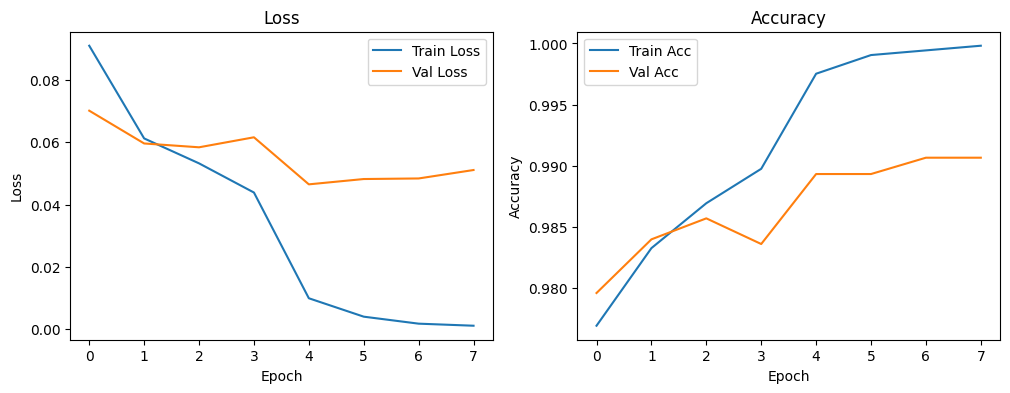

In [72]:
# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [76]:
# 검증 데이터에 대한 예측 및 분류 보고서
y_pred = model.predict([X_val_input_ids, X_val_attention_mask])
y_pred_classes = np.argmax(y_pred, axis=1)

report = classification_report(y_val, y_pred_classes, target_names=label_mapping.keys(), output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df[['precision', 'recall', 'f1-score', 'support']]
report_df = report_df.round(4)
report_df

,precision,recall,f1-score,support
협박 대화,0.9844,0.9748,0.9796,713.0000
갈취 대화,0.9880,0.9880,0.9880,913.0000
직장 내 괴롭힘 대화,0.9824,0.9891,0.9857,732.0000
기타 괴롭힘 대화,0.9823,0.9853,0.9838,955.0000
일반 대화,0.9979,0.9974,0.9977,1937.0000
accuracy,0.9893,0.9893,0.9893,0.9893
macro avg,0.9870,0.9869,0.9869,5250.0000
weighted avg,0.9893,0.9893,0.9893,5250.0000


In [77]:
from tensorflow.keras.models import load_model

# 저장된 모델의 가중치를 불러오는 경로 설정
model_path = os.path.join('checkpoints', 'best_model.h5')

In [78]:
!pip install kiwipiepy
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords
kiwi=Kiwi()
stopwords =Stopwords()

In [79]:
class TextProcessor:
    def __init__(self):
        self.kiwi = Kiwi(typos='basic_with_continual_and_lengthening')
        self.stopwords = Stopwords()
        
    # 데이터 정제 (불필요한 문자, 특수 문자, 이메일, URL, 자음/모음 등 제거)
    def clean_text(self, text):
        # E-mail 제거
        text = re.sub(r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)', '', text)
        # URL 제거
        text = re.sub(r'(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text)
        # 한글 자음, 모음 제거
        text = re.sub(r'([ㄱ-ㅎㅏ-ㅣ]+)', '', text)
        # 알파벳, 숫자 제거
        text = re.sub(r'([a-zA-Z0-9]+)', '', text)
        # HTML 태그 제거
        text = re.sub(r'<[^>]*>', '', text)
        # 특수 기호 제거
        text = re.sub(r'[^\w\s]', '', text)
        # 한글과 공백을 제외한 모든 문자 제거
        text = re.sub(r'[^가-힣\s]', '', text)
        # 다중 공백을 단일 공백으로
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    # 형태소 분석 및 불용어 제거
    def analyze_morphs(self, text):
        # 형태소 분석 수행 및 불용어 제거
        tokens = [(token.form,token.tag )for token in self.kiwi.tokenize(text, stopwords=self.stopwords)]
        return tokens
    
    # 'EF' 태그가 있는 형태소 제거
    def filter_ef_tag(self, tokens):
        # 'EF' 품사 태그가 있는 형태소 제거
        filtered_tokens = [token[0] for token in tokens if token[1] != 'EF']
        filtered_tokens = [token[0] for token in tokens if token[1] != 'EC']
        filtered_tokens = [token[0] for token in tokens if token[1] != 'JKO']
        return filtered_tokens

    # 추가적인 단어 필터링
    def filter_specific_words(self, tokens):
        words_to_remove = ['ㅂ니다', '안', '야', '너', '키키', '키', '거', 'ㄴ가요', '습니다']
        filtered_tokens = [token for token in tokens if token not in words_to_remove]
        return filtered_tokens

    # 전체 과정 통합 (형태소 분석, EF 품사 및 불용어 제거)
    def process(self, text):
        cleaned_text = self.clean_text(text)
        tokens = self.analyze_morphs(cleaned_text)
        tokens_without_ef = self.filter_ef_tag(tokens)
        filtered_tokens = self.filter_specific_words(tokens_without_ef)
        return filtered_tokens
    
processor = TextProcessor()

In [80]:
# 1. 저장된 모델 불러오기
model.load_weights(model_path)

In [81]:
# 2. 테스트 데이터 로드
test_data_path = '~/2024_DKTC/data/test.csv'
test_df = pd.read_csv(test_data_path)

In [82]:
# 3. 테스트 데이터 전처리 (훈련 데이터와 동일한 방식으로)
test_df['ppc'] = test_df['text'].apply(lambda text: processor.process(text))
test_df['processed_text'] = test_df['ppc'].apply(lambda tokens: ' '.join(tokens))

In [83]:
# 4. 토큰화된 테스트 데이터 생성
tokenized_test_data = tokenize_texts(test_df['processed_text'], tokenizer, max_seq_len)
input_ids_test = tokenized_test_data['input_ids']
attention_mask_test = tokenized_test_data['attention_mask']

In [102]:
# 5. 모델로 예측 수행
y_test_pred = model.predict([input_ids_test, attention_mask_test])

In [103]:
# 6. 예측 클래스 추출
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

In [104]:
# Threshold 값 설정
threshold = 0.5

In [105]:
# 7. 일반 대화에 대한 threshold 적용
# 각 클래스의 확률에서 일반 대화의 확률(y_test_pred[:, 4])이 threshold 이상일 때, '일반 대화'로 강제 분류
for i in range(len(y_test_pred)):
    general_conversation_prob = y_test_pred[i, 4]  # 일반 대화의 확률
    if general_conversation_prob >= threshold:
        y_test_pred_classes[i] = 4  # 일반 대화로 분류
        
# 예측 클래스 값 확인 (디버깅용)
print("예측 클래스 값 (threshold 적용 후):", y_test_pred_classes)

예측 클래스 값 (threshold 적용 후): [1 2 2 4 1 0 0 1 3 1 0 4 2 2 2 0 4 3 0 3 0 3 3 1 1 2 3 4 2 0 1 0 4 1 0 3 3
 1 3 1 0 1 2 1 4 2 0 3 4 0 1 3 1 2 2 3 3 4 3 3 1 2 0 3 2 0 4 3 3 0 4 2 3 2
 0 4 2 3 2 4 1 0 0 1 3 2 0 4 1 2 0 2 0 3 3 2 1 2 0 0 1 1 4 0 3 2 2 3 4 0 4
 0 0 2 1 1 4 2 2 1 2 2 1 1 1 1 2 4 1 3 3 3 2 3 1 0 3 0 3 1 3 4 1 3 2 0 0 0
 3 1 0 3 0 1 2 4 0 2 3 3 0 3 4 0 3 3 2 4 3 1 0 2 2 3 4 3 0 2 0 3 2 3 2 2 0
 4 1 0 1 0 0 3 1 3 1 3 0 4 3 3 2 0 0 3 0 3 2 2 2 2 4 1 3 2 0 4 3 4 1 0 1 4
 0 4 0 4 1 0 1 0 2 0 0 3 1 3 4 1 0 3 3 3 3 2 4 1 2 3 2 1 0 2 0 2 2 1 3 2 1
 2 1 0 1 3 2 3 3 4 2 3 0 4 0 2 4 2 2 3 2 2 1 0 3 2 4 2 1 2 1 3 1 1 3 3 2 3
 4 4 1 0 4 3 0 2 1 1 3 3 1 2 0 1 4 4 2 3 0 3 4 1 2 0 0 1 1 1 1 4 2 3 1 0 0
 3 1 4 3 1 4 3 0 2 0 0 1 2 4 1 0 0 0 3 1 1 1 0 3 3 0 1 3 4 1 1 2 4 0 2 3 1
 1 2 0 2 2 1 1 0 1 1 2 0 2 2 3 3 4 0 0 3 1 0 1 2 1 2 0 1 1 3 3 3 2 2 3 3 2
 1 2 1 0 3 0 2 2 4 3 1 1 3 0 1 0 3 3 1 1 2 2 0 3 4 1 0 1 3 0 4 4 2 3 0 2 1
 4 2 0 2 2 4 1 0 2 3 4 1 2 3 1 1 4 1 2 2 2 3 3 2 4 0 2 1 0 4 3 2 1 4 4 2 

In [106]:
# 8. 예측 클래스 번호를 텍스트 레이블로 변환
test_df['class'] = y_test_pred_classes

In [107]:
# 8. 제출 파일 작성
submission = test_df[['idx', 'class']]
submission.columns = ['idx', 'target']
submission.to_csv('~/2024_DKTC/data/submission.csv', index=False)

In [108]:
test_df['class'].unique()

array([1, 2, 4, 0, 3], dtype=int64)

In [109]:
test_df['class'].value_counts()

1    111
3    111
2    108
0    103
4     67
Name: class, dtype: int64

In [95]:
import pandas as pd

# 파일 경로에 맞게 수정해주세요
submission_before = pd.read_csv('~/2024_DKTC/result/submission (23).csv')
submission_after = pd.read_csv('~/2024_DKTC/result/submission (29).csv')

# target 값이 다른 항목 필터링
differences = submission_before[submission_before['target'] != submission_after['target']]

# 차이가 나는 idx 개수 출력
difference_count = differences.shape[0]

print(f"Target 값이 다른 idx 개수: {difference_count}")

Target 값이 다른 idx 개수: 101
